<a href="https://colab.research.google.com/github/vprzybylo/AIE5/blob/main/Prototyping_LangChain_Application_with_Production_Minded_Changes_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 24.4 MB/s eta 0:00:00


We'll need an OpenAI API Key:

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [4]:
import uuid
import os
import getpass
os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [6]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - b46cb2c4


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [8]:
from google.colab import files
uploaded = files.upload()

Saving DeepSeek R1.pdf to DeepSeek R1.pdf


In [9]:
file_path = list(uploaded.keys())[0]
file_path

'DeepSeek R1.pdf'

We'll define our chunking strategy.

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [11]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [12]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

**Limitations:**

Storage: LocalFileStore might not be suitable for large datasets or cloud environments. Consider more robust solutions like Redis or cloud storage for better scalability.

Cache Invalidation: The current setup doesn't automatically invalidate the cache when the underlying data changes. Manual cache management might be needed.

Cold Start: The cache needs to be populated initially, leading to slower performance for the first few queries.

**When is it Most Useful:**

Repeated Queries: Ideal for scenarios where the same or similar queries are frequent, like chatbot interactions or repeated document searches.

Static Data: Works well when the underlying data is relatively stable and doesn't change frequently.

Latency Reduction: Improves response times for repeated queries by avoiding redundant embedding computations.

**When is it Least Useful:**

Dynamic Data: Not suitable for rapidly changing data, as the cache might become stale quickly.

Unique Queries: Limited benefits when queries are diverse and rarely repeated.

Resource Constraints: LocalFileStore might not be ideal for environments with limited storage capacity.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [19]:
import time
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

# Initialize embeddings and cache
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Larger sample text (repeated)
large_text = """This is a larger sample text to test cache-backed embeddings.
It contains multiple sentences and paragraphs to simulate a more realistic scenario.
The goal is to evaluate the performance of cache-backed embeddings when dealing with longer texts.
By repeating this text in the experiment, we can observe the speedup achieved by caching the embeddings.""" * 10  # Repeat 10 times

text_two = "You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context."

texts = [
    large_text,
    text_two,
]

def time_embedding(embedder, text):
    start_time = time.time()
    _ = embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

# Run experiment and print results
for i, text in enumerate(texts):
    print(f"\nText {i + 1}:")

    # First embedding (not cached)
    first_time = time_embedding(cached_embedder, text)
    print(f"  First embedding time: {first_time:.4f} seconds")

    # Second embedding (should be cached if repeated)
    second_time = time_embedding(cached_embedder, text)
    print(f"  Second embedding time: {second_time:.4f} seconds")

    # Calculate and print speedup
    speedup = (first_time - second_time) / first_time * 100 if first_time > 0 else 0
    print(f"  Speedup: {speedup:.2f}%")


Text 1:
  First embedding time: 0.7390 seconds
  Second embedding time: 0.3287 seconds
  Speedup: 55.52%

Text 2:
  First embedding time: 1.3685 seconds
  Second embedding time: 0.3151 seconds
  Speedup: 76.97%


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [20]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [21]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [22]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

**Limitations of LLM Prompt Caching with InMemoryCache**

**Memory Capacity:** InMemoryCache stores cached data in RAM, which can become a bottleneck for large datasets or frequent updates. This approach is not suitable for scenarios requiring persistent or distributed caching.

**Cache Consistency:** Maintaining consistency between the cached responses and the underlying LLM or data store is crucial. Cache invalidation strategies are needed to ensure accuracy and prevent serving outdated information.

**Context Limits:** InMemoryCache might not be ideal for applications with extensive context requirements or long-running conversations. Consider alternative caching mechanisms with larger capacity and persistence for such scenarios.

**Exact Match Requirement:** The current implementation relies on exact prompt matching for cache hits. Slight variations in prompts can result in cache misses, limiting the effectiveness of the cache.

**Cold Start Problem:** Initially, the cache is empty, leading to slower responses until it gets populated with frequently used prompts and responses.

**When is LLM Prompt Caching Most Useful?**

**Repetitive Queries:** When dealing with scenarios where the same prompts are frequently executed, such as in customer support chatbots or interactive tutorials, caching can significantly reduce latency and improve responsiveness.
Static Prompts and Responses: When the prompts and expected responses are relatively stable and don't change often, caching can provide long-term benefits without the risk of serving outdated information.

**Latency-Sensitive Applications:** For applications where response time is critical, caching can help minimize delays and ensure a smooth user experience.

**When is LLM Prompt Caching Least Useful?**

**Dynamic Data and Prompts:** When the underlying data or prompts are constantly changing, caching can become less effective due to the risk of serving outdated information. Frequent cache invalidation might be needed, which can introduce overhead.

**Variable Prompts:** If the prompts are diverse and rarely repeated, the cache hit rate will be low, and the benefits of caching will be minimal.

**Large Context Requirements:** For applications requiring extensive context or long-running conversations, InMemoryCache might not be the most suitable option due to its limited capacity.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [23]:
import time
from langchain_openai import ChatOpenAI
from langchain_core.caches import InMemoryCache
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.globals import set_llm_cache

# Initialize chat model and cache
chat_model = ChatOpenAI(model="gpt-4o-mini")
set_llm_cache(InMemoryCache())


# Test cases with varying questions and contexts
test_cases = [
    {
        "question": "What is the capital of France?",
        "context": "France is a country in Europe. Its capital is Paris."
    },
    {
        "question": "What is the capital of France?",  # Same question, different context
        "context": "Paris is the most populous city in France and is known for its iconic landmarks like the Eiffel Tower."
    },
    {
        "question": "What is the highest mountain in the world?",  # Different question, different context
        "context": "Mount Everest is the highest mountain in the world, located in the Mahalangur Himal sub-range of the Himalayas."
    },
    {
        "question": "What is the population of Japan?",  # Different question, different context
        "context": "Japan is an island country in East Asia. It has a population of over 126 million people."
    },
    {
        "question": "What is the population of Japan?",  # Same question, same context - for cache check
        "context": "Japan is an island country in East Asia. It has a population of over 126 million people."
    },
]

# Run tests and measure response times
response_times = []
responses = []

for i, test_case in enumerate(test_cases):
    start_time = time.time()

    # Format the prompt with the test case
    messages = chat_prompt.format_messages(
        question=test_case["question"],
        context=test_case["context"]
    )

    # Get response
    response = chat_model.predict_messages(messages)
    end_time = time.time()

    response_times.append(end_time - start_time)
    responses.append(response)

    print(f"\nTest Case {i + 1}")
    print(f"Question: {test_case['question']}")
    print(f"Response: {response.content}")
    print(f"Response time: {response_times[-1]:.2f} seconds")

    # Check if response was cached (for second iteration)
    if i >= 1 and test_cases[i]['question'] == test_cases[i - 1]['question'] and test_cases[i]['context'] == test_cases[i - 1]['context']:
        original_time = response_times[i - 1]
        cached_time = response_times[i]
        speedup = original_time / cached_time
        print(f"Cache speedup: {speedup:.2f}x faster")

        # Verify responses match
        if responses[i - 1].content == responses[i].content:
            print("✅ Cached response matches original")
        else:
            print("❌ Warning: Cached response differs from original")
    else:
        print("Cache miss - Unique Question or Context")

<ipython-input-23-7659af86c40e>:50: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat_model.predict_messages(messages)



Test Case 1
Question: What is the capital of France?
Response: The capital of France is Paris.
Response time: 1.28 seconds
Cache miss - Unique Question or Context

Test Case 2
Question: What is the capital of France?
Response: The capital of France is Paris.
Response time: 0.75 seconds
Cache miss - Unique Question or Context

Test Case 3
Question: What is the highest mountain in the world?
Response: The highest mountain in the world is Mount Everest, which is located in the Mahalangur Himal sub-range of the Himalayas.
Response time: 1.00 seconds
Cache miss - Unique Question or Context

Test Case 4
Question: What is the population of Japan?
Response: The population of Japan is over 126 million people.
Response time: 0.57 seconds
Cache miss - Unique Question or Context

Test Case 5
Question: What is the population of Japan?
Response: The population of Japan is over 126 million people.
Response time: 0.00 seconds
Cache speedup: 279.04x faster
✅ Cached response matches original


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [24]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [25]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "DeepSeek R1" and is in PDF format.\n2. It contains a total of 22 pages.\n3. The document was created using LaTeX with hyperref.\n4. The producer of the PDF is pdfTeX version 1.40.26.\n5. It was created and last modified on January 23, 2025.\n6. The document includes evaluation metrics for various models.\n7. It compares the performance of Claude-3.5, GPT-4o, and DeepSeek models.\n8. The performance metrics include English MMLU (Pass@1).\n9. DeepSeek shows a Pass@1 score of 88.5 in MMLU.\n10. The MMLU-Redux (EM) score for DeepSeek is 89.1.\n11. The MMLU-Pro (EM) score for DeepSeek is 75.9.\n12. DeepSeek achieves a DROP (3-shot F1) score of 91.6.\n13. IF-Eval (Prompt Strict) score for DeepSeek is 86.1.\n14. GPQA Diamond (Pass@1) score for DeepSeek is 59.1.\n15. SimpleQA (Correct) score for DeepSeek is 24.9.\n16. FRAMES (Acc.) score for DeepSeek is 73.3.\n17. AlpacaEval2.0 (LC-winrate) score for DeepSeek is 70.0.\n18. ArenaHard (GPT-4-1106) sc

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

Notice how the first question on Japan (3rd row) took 0.57s and the identical question/context after (2nd row) took 0.00s. That is because the prompt was cached and there wan't an unnecessary call to the OpenAI API.

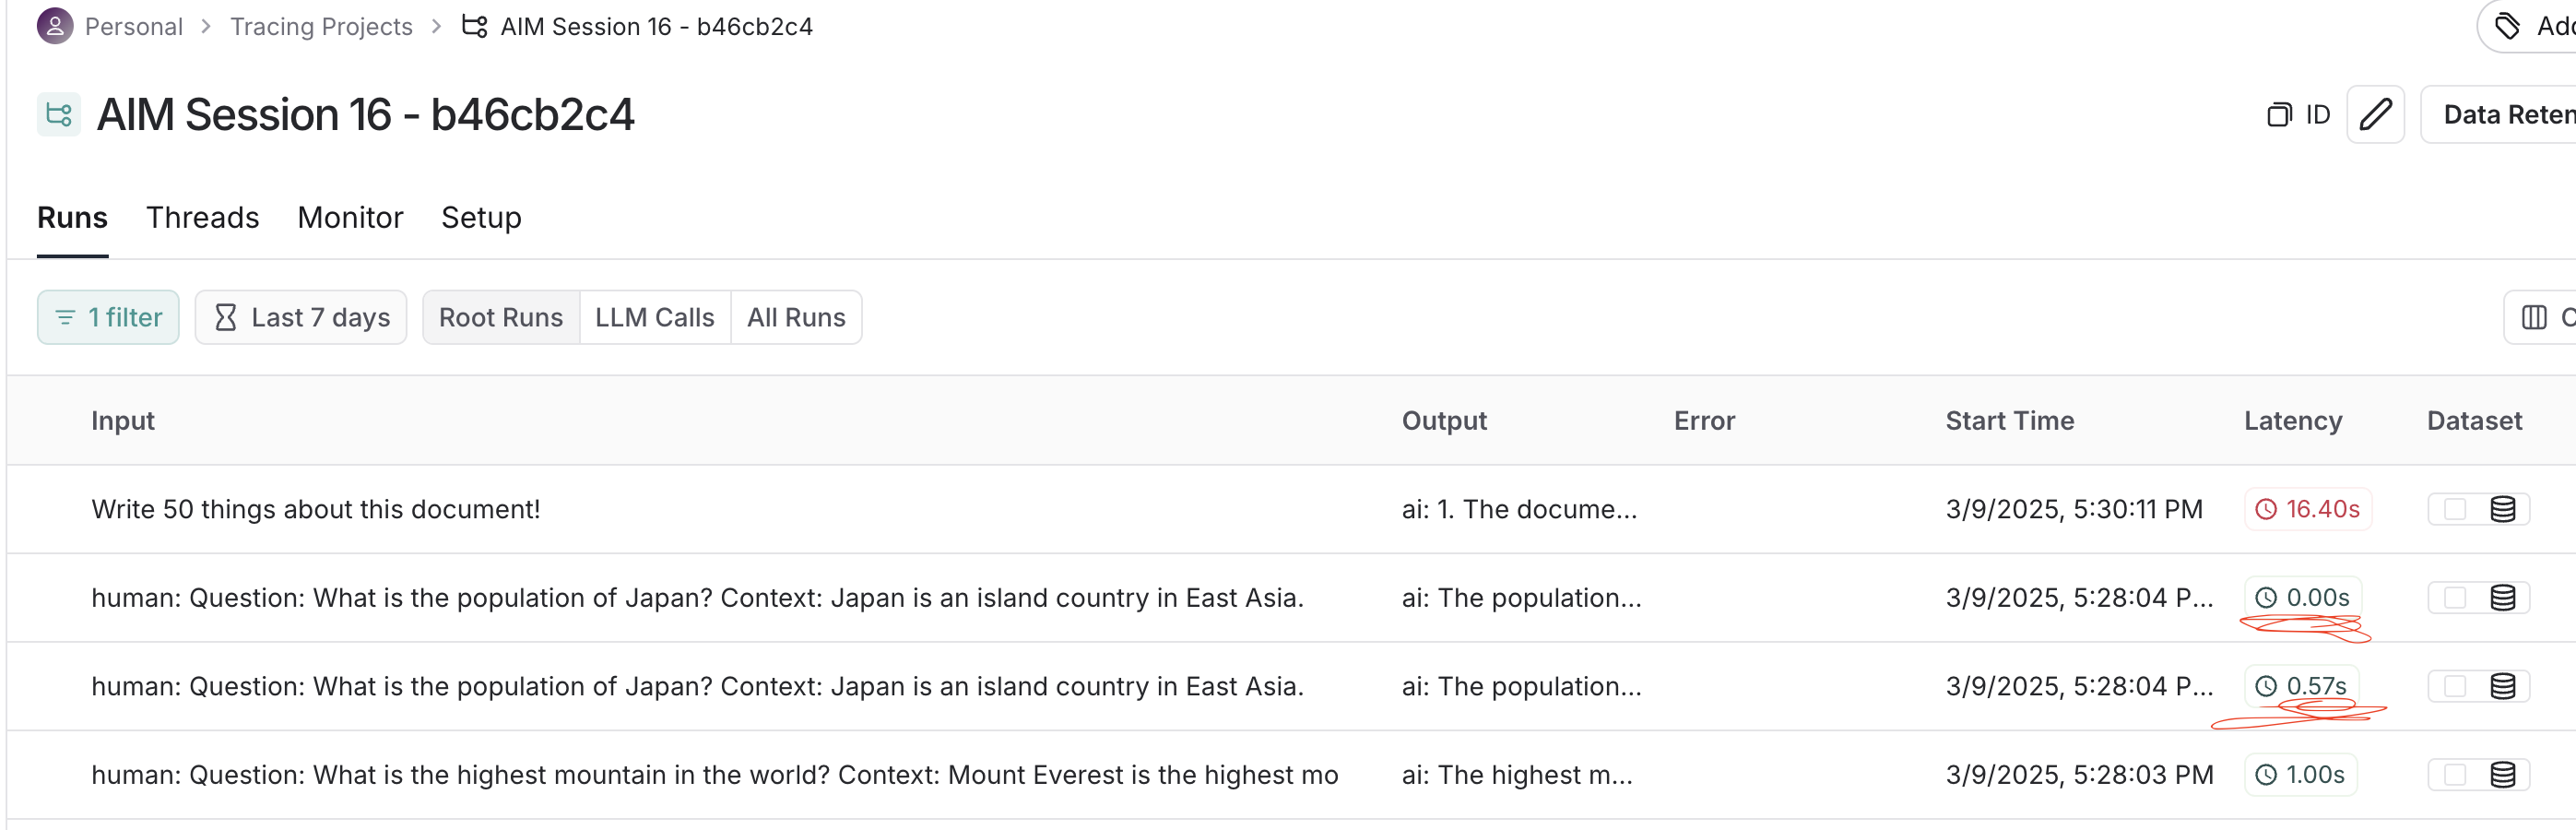